# Predicting Breast Cancer Diagnosis Using Logistic Regression

This dataset is from the UCI Machine Learning Repository, downloaded from Kaggle. Link [here](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

Ten real-valued features are computed for each cell nucleus:

a) **radius** (mean of distances from center to points on the perimeter)<br>
b) **texture** (standard deviation of gray-scale values)<br>
c) **perimeter**<br>
d) **area**<br>
e) **smoothness** (local variation in radius lengths)<br>
f) **compactness** (perimeter^2 / area - 1.0)<br>
g) **concavity** (severity of concave portions of the contour)<br>
h) **concave points** (number of concave portions of the contour)<br>
i) **symmetry**<br>
j) **fractal dimension** ("coastline approximation" - 1)<br>

The columns names ending with "se" or "worst" refer to the standard error or the maximum of that feature observed, respectively.

The target column is the binary "diagnosis" column.

# Summary

#### LogisticRegression after 5-fold cross-validation
    * Unscaled
        Test accuracy: 0.9206
        Recall: 0.8805
    * Scaled
        Test accuracy: 0.9648
        Recall: 0.9305
    * Unscaled after dropping low-importance columns:
        Test accuracy: 0.9296
        Recall: 0.9055
    * Scaled after dropping low_importance columns:
        Test accuracy: 0.9383
        Recall: 0.9305

In [95]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, recall_score, make_scorer

In [65]:
cancer = pd.read_csv('breast_cancer.csv')

cancer = cancer.drop(['Unnamed: 32', 'id'], axis = 1)

In [66]:
diag_map = {'B':0, 'M': 1}

cancer['diagnosis'] = cancer['diagnosis'].map(diag_map)

In [67]:
X = cancer.drop('diagnosis', 1)
y = cancer['diagnosis']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify = y)

In [69]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Unscaled

In [70]:
lr_grid = {
    'C': [0.1, 1, 10, 20],
    'solver': ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga'],
    'max_iter': [100, 1000, 10000]
}

model_lr_grid = GridSearchCV(LogisticRegression(max_iter = 1000), param_grid = lr_grid, verbose = 1, n_jobs = -1)
model_lr_grid.fit(X_train, y_train)

print(model_lr_grid.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:   23.3s


{'C': 20, 'max_iter': 100, 'solver': 'newton-cg'}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.8s finished


In [89]:
%time
model_lr = LogisticRegression(C= 20, solver = 'newton-cg', max_iter = 1000)
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_lr),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)


print('Training Score: {}'.format(model_lr.score(X_train, y_train)))
print('Test Score: {}'.format(model_lr.score(X_test, y_test)))
print(classification_report(y_test, y_pred_lr))
print(confusion_df)

Wall time: 0 ns
Training Score: 0.9736263736263736
Test Score: 0.956140350877193
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        72
           1       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              71               1
Actually Mal.               4              38


In [96]:
cv_scores = cross_val_score(model_lr, X_test, y_test, cv = 5)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_lr, X_test, y_test, cv = 5, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

Mean cross val accuracy: 0.9205533596837945
Mean cross val recall: 0.8805555555555555


In [72]:
coef = model_lr_grid.best_estimator_.coef_[0]
im_df = pd.DataFrame({"feat": X_train.columns, "coef_sq": coef ** 2})
im_df.sort_values("coef_sq", ascending=False)

,feat,coef_sq
27,concave points_worst,2.296185e+01
28,symmetry_worst,1.873375e+01
26,concavity_worst,1.818486e+01
0,radius_mean,1.614987e+01
24,smoothness_worst,1.057438e+01
6,concavity_mean,8.086143e+00
11,texture_se,7.256004e+00
7,concave points_mean,6.560612e+00
8,symmetry_mean,4.850327e+00
15,compactness_se,3.625108e+00


## Scaled

In [74]:
model_lr_grid_s = GridSearchCV(LogisticRegression(), param_grid = lr_grid, verbose = 1, n_jobs = -1)
model_lr_grid_s.fit(X_train_scaled, y_train)
print(model_lr_grid.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:    2.1s


{'C': 20, 'max_iter': 100, 'solver': 'newton-cg'}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    6.5s finished
C:\Users\rhais\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [75]:
%time
model_lr_scale = LogisticRegression(C= 20, solver = 'newton-cg', max_iter = 100)
model_lr_scale.fit(X_train_scaled, y_train)

y_pred_lr_s = model_lr_scale.predict(X_test_scaled)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_lr_s),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)


print('Training Score: {}'.format(model_lr_scale.score(X_train_scaled, y_train)))
print('Test Score: {}'.format(model_lr_scale.score(X_test_scaled, y_test)))
print(classification_report(y_test, y_pred_lr_s))
print(confusion_df)

Wall time: 0 ns
Training Score: 0.989010989010989
Test Score: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              71               1
Actually Mal.               2              40


In [97]:
cv_scores = cross_val_score(model_lr_scale, X_test_scaled, y_test, cv = 5)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_lr_scale, X_test_scaled, y_test, cv = 5, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

Mean cross val accuracy: 0.9648221343873518
Mean cross val recall: 0.9305555555555556


In [12]:
coef = model_lr_grid_s.best_estimator_.coef_[0]
im_df = pd.DataFrame({"feat": X_train.columns, "coef_sq": coef **2})
im_df.sort_values("coef_sq", ascending=False)

,feat,coef_sq
10,radius_se,0.972871
21,texture_worst,0.888676
20,radius_worst,0.716831
27,concave points_worst,0.680193
26,concavity_worst,0.662005
23,area_worst,0.619991
22,perimeter_worst,0.573714
13,area_se,0.549628
7,concave points_mean,0.496218
12,perimeter_se,0.494053


# Dropping low-importance columns

Threshold = 0.1

## Unscaled

In [13]:
cancer_dropped_u = cancer.drop(columns=['concave points_se',
                                        'symmetry_se',
                                       'compactness_mean',
                                       'texture_mean',
                                       'concavity_se',
                                       'fractal_dimension_mean',
                                       'area_mean',
                                       'perimeter_mean',
                                       'concave points_mean',
                                       'area_se',
                                       'perimeter_worst',
                                       'area_worst'])

X = cancer_dropped_u.drop(columns = 'diagnosis')

y = cancer_dropped_u['diagnosis']

X_train_op, X_test_op, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify = y)

In [14]:
lr_grid = {
    'C': [0.1, 1, 10, 20],
    'solver': ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga'],
    'max_iter': [100, 1000, 10000, 100000]
}

model_lr_grid = GridSearchCV(LogisticRegression(max_iter = 1000), param_grid = lr_grid, verbose = 1, n_jobs = -1)
model_lr_grid.fit(X_train_op, y_train)

print(model_lr_grid.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:    6.0s


{'C': 20, 'max_iter': 100, 'solver': 'newton-cg'}


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   18.8s finished


In [15]:
%time
model_lr_op = LogisticRegression(C= 20, solver = 'newton-cg', max_iter = 100)
model_lr_op.fit(X_train_op, y_train)

y_pred_lr = model_lr_op.predict(X_test_op)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_lr),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)


print('Training Score: {}'.format(model_lr_op.score(X_train_op, y_train)))
print('Test Score: {}'.format(model_lr_op.score(X_test_op, y_test)))
print(classification_report(y_test, y_pred_lr))
print(confusion_df)

Wall time: 0 ns
Training Score: 0.967032967032967
Test Score: 0.956140350877193
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        72
           1       0.97      0.90      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              71               1
Actually Mal.               4              38


In [98]:
cv_scores = cross_val_score(model_lr_op, X_test_op, y_test, cv = 5)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_lr_op, X_test_op, y_test, cv = 5, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

Mean cross val accuracy: 0.9296442687747035
Mean cross val recall: 0.9055555555555556


## Scaled

In [16]:
cancer_dropped_s = cancer.drop(columns=['concave points_se',
                                        'smoothness_se',
                                        'symmetry_se',
                                       'compactness_mean',
                                       'symmetry_se',
                                       'texture_se',
                                       'smoothness_mean',
                                       'compactness_worst',
                                       'concavity_se',
                                       'fractal_dimension_worst',
                                       'symmetry_mean'])

X = cancer_dropped_s.drop(columns = 'diagnosis')

y = cancer_dropped_s['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify = y)

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled_op = scaler.transform(X_train)
X_test_scaled_op = scaler.transform(X_test)

In [18]:
model_lr_grid_s = GridSearchCV(LogisticRegression(), param_grid = lr_grid, verbose = 1, n_jobs = -1)
model_lr_grid_s.fit(X_train_scaled_op, y_train)
print(model_lr_grid_s.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    4.1s


{'C': 10, 'max_iter': 100, 'solver': 'saga'}


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    9.2s finished
C:\Users\rhais\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [19]:
%time
model_lr_scale_op = LogisticRegression(C= 10, solver = 'saga', 
                                       max_iter = 10000)
model_lr_scale_op.fit(X_train_scaled_op, y_train)

y_pred_lr_s = model_lr_scale_op.predict(X_test_scaled_op)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_lr_s),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)


print('Training Score: {}'.format(model_lr_scale_op.score(X_train_scaled_op, y_train)))
print('Test Score: {}'.format(model_lr_scale_op.score(X_test_scaled_op, y_test)))
print(classification_report(y_test, y_pred_lr_s))
print(confusion_df)

Wall time: 0 ns
Training Score: 0.989010989010989
Test Score: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              70               2
Actually Mal.               1              41


In [99]:
cv_scores = cross_val_score(model_lr_scale_op, X_test_scaled_op, y_test, cv = 5)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_lr_scale_op, X_test_scaled_op, y_test, cv = 5, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

Mean cross val accuracy: 0.9383399209486166
Mean cross val recall: 0.9305555555555556


# ROC curve for unscaled

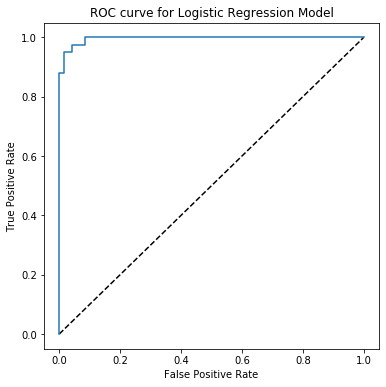

In [38]:
probs = model_lr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression Model')
plt.show()

# ROC curve for scaled

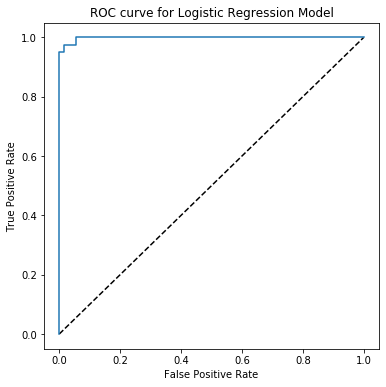

In [39]:
probs = model_lr_scale.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression Model')
plt.show()

# ROC curve for unscaled optimized

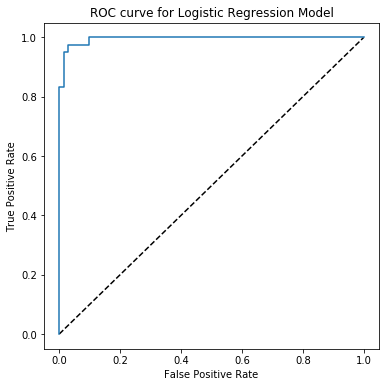

In [40]:
probs = model_lr_op.predict_proba(X_test_op)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression Model')
plt.show()

# ROC curve for scaled optimized

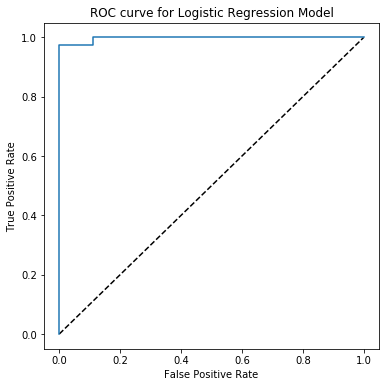

In [41]:
probs = model_lr_scale_op.predict_proba(X_test_scaled_op)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression Model')
plt.show()

# Model Confidence

## Unscaled

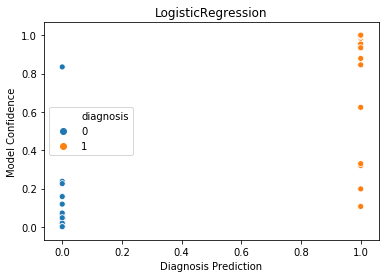

In [85]:
confidence = model_lr.predict_proba(X_test)[:, 1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence')
plt.xlabel('Diagnosis Prediction')
plt.title('LogisticRegression')
plt.show()

## Scaled

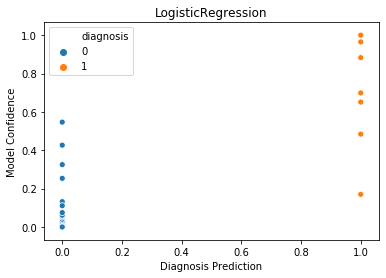

In [83]:
confidence = model_lr_scale.predict_proba(X_test_scaled)[:, 1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence')
plt.xlabel('Diagnosis Prediction')
plt.title('LogisticRegression')
plt.show()

## Unscaled optimized

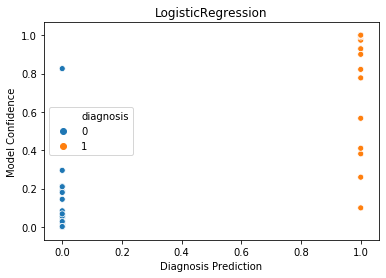

In [86]:
confidence = model_lr_op.predict_proba(X_test_op)[:, 1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence')
plt.xlabel('Diagnosis Prediction')
plt.title('LogisticRegression')
plt.show()

## Scaled Optimized

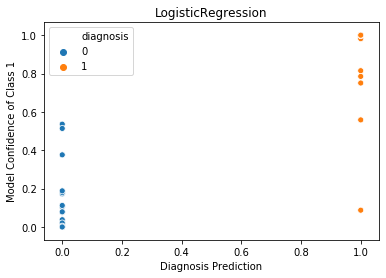

In [87]:
confidence = model_lr_scale_op.predict_proba(X_test_scaled_op)[:, 1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('LogisticRegression')
plt.show()

Scaled and optimized appears to be the best model in this notebook. It has the highest cross-validated accuracy, its recall is highest, and it is confident in its predictions.